This notebook prepares the ebutterfly data, co-located with ebird, starts with clustering the observations around ebird hotspots (using BallTree), creates the targets by aggregating the checklists, saves final csv for the hotspots

# 1. get intersections between ebutterfly and ebird data

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from haversine import haversine, Unit
from sklearn.neighbors import BallTree
import os

In [3]:
root_dir = "/home/hagerradi/projects/Ecosystem_embeddings/ebutterfly/Darwin/0177350-230224095556074"
dataset_tag = "ebutterfly_data_v5"

In [ ]:
buttefly_data_US = pd.read_csv(os.path.join(root_dir, "occ_usa.csv"))

In [ ]:
buttefly_data_US

In [ ]:
buttefly_data_US = buttefly_data_US.drop_duplicates()

In [ ]:
buttefly_data_US['genus'].value_counts()

In [ ]:
buttefly_data_US

In [ ]:

satbird_USA_summer = pd.read_csv(os.path.join(root_dir, dataset_tag, "all_summer_hotspots_final.csv"))

print(satbird_USA_summer)
print(buttefly_data_US)

RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

# KNN based on BallTree, used for clustering the data points
class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X):
        self.X_train = X
        self.tree = BallTree(np.deg2rad(X), metric='haversine')

    def haversine_distance(self, x1, x2):
        return haversine((x1[0], x1[1]), (x2[0], x2[1]), unit=Unit.KILOMETERS)

    def predict_slow(self, X):
        dist, index = [], []
        for x in tqdm(X):
            d, i = self._predict_single(x)
            dist.append(d)
            index.append(i)
        return np.array(dist), np.array(index)
    
    def predict(self, X):
        dist, index = self.tree.query(np.deg2rad(X), k=self.k)
        dist = dist * RADIUS_EARTH
        return dist, index

    def _predict_single(self, x):
        # Compute distances between x and all examples in the training set
        distances = [self.haversine_distance(x, x_train) for x_train in self.X_train]
        # Get indices of k nearest neighbors
        return min(distances), np.argmin(distances)

coordinates = buttefly_data_US[['decimalLatitude', 'decimalLongitude']].values
center_coordinates = satbird_USA_summer[['lat', 'lon']].values

# Create a KNN classifier, with k=1
knn = KNN(k=1)

# fit ebird hotspots
knn.fit(center_coordinates)

# cluster ebutterfly observations into ebird hotspts
distances, indices = knn.predict(coordinates)

print(len(distances), distances.min(), distances.max())
print(len(indices))

buttefly_data_US['ebird_hotspot'] = satbird_USA_summer.iloc[indices.flatten()]['hotspot_id'].values
buttefly_data_US['ebird_lon'] = satbird_USA_summer.iloc[indices.flatten()]['lon'].values
buttefly_data_US['ebird_lat'] = satbird_USA_summer.iloc[indices.flatten()]['lat'].values
buttefly_data_US['distance'] = distances
buttefly_data_US['ebird_split'] = satbird_USA_summer.iloc[indices.flatten()]['split'].values

km_threshold = 1

# final butterfly data after filtering out outliers
filtered_butterfly_data = buttefly_data_US[buttefly_data_US.distance < km_threshold].reset_index()

print(filtered_butterfly_data['ebird_hotspot'].value_counts())
print(filtered_butterfly_data)
print(filtered_butterfly_data[['decimalLatitude', 'decimalLongitude', 'ebird_hotspot', 'ebird_lat', 'ebird_lon', 'distance', 'ebird_split']])

filtered_butterfly_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_with_distance.csv"))

# 2. some analysis

In [ ]:
satbird_USA_summer.columns

In [ ]:
hotspots = filtered_butterfly_data['ebird_hotspot'].value_counts()

print(hotspots)

print(len(hotspots > 1000))
print(hotspots.min(), hotspots.max(), hotspots.mean(), hotspots.median())

value_counts_filtered = hotspots[hotspots > 200]

print(value_counts_filtered)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# plt.hist(hotspots, density=False, bins=30)  # density=False would make counts
plt.plot(hotspots.keys(), hotspots)  # density=False would make counts
plt.show()

In [ ]:
del distances
del knn

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
# import cartopy
# import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

# ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
# ax.coastlines()

colors = {'train': 'b', 'test':'y', 'valid':'m'}

# ax.plot(tiny_butterfly['decimalLongitude'], tiny_butterfly['decimalLatitude'], 'go', transform=ccrs.PlateCarree())
# ax.plot(tiny_butterfly['ebird_lon'], tiny_butterfly['ebird_lat'], 'ro', transform=ccrs.PlateCarree())

ax.scatter(x=filtered_butterfly_data['ebird_lon'], y=filtered_butterfly_data['ebird_lat'], color='grey')
# ax.scatter(x=filtered_butterfly_data['decimalLongitude'], y=filtered_butterfly_data['decimalLatitude'], color='red')
ax.scatter(x=center_lons, y=center_lats, color='green')

# ax.scatter(x=tiny_satbird['lon'], y=tiny_satbird['lat'], color='blue')

plt.show()

ax.set_title('Coordinates on USA Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [ ]:
filtered_butterfly_data

# 3. group butterfly checklists based on final hotspots

In [ ]:
filtered_butterfly_data = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_data_with_distance.csv"))
grouped_butterfly_data = filtered_butterfly_data.groupby(['ebird_hotspot'])
group_sizes = grouped_butterfly_data.size()
print(group_sizes)

In [ ]:
filtered_butterfly_data["species"].value_counts() # doesn't include Nands

In [ ]:
filtered_butterfly_data["species"].unique().tolist() # includes Nans

In [ ]:
# save species list of all unique species

species_df = filtered_butterfly_data['species'].value_counts()

species_df = species_df.reset_index()
species_df.columns = ['species', 'frequency']

species_df.to_csv(os.path.join(root_dir, dataset_tag, 'species_list.csv'), index=False)

species_list = species_df["species"].values.tolist()

print(species_list)
print(len(species_list))

In [ ]:
total_number_of_checklists = len(filtered_butterfly_data["eventID"].unique().tolist())
print(total_number_of_checklists)

# External Update to species list 

starts here >>>>>>>>>>>>>>>>

In [6]:
## correction: use an updated species list which drops one species, and re-generated the targets
species_list = pd.read_csv(os.path.join(root_dir, dataset_tag, 'species_list_updated.csv'))
# print(species_list[species_list['frequency'] > 1])
# species_list = species_list[species_list['frequency'] >= 100]['species']
print(len(species_list))
species_list.to_csv(os.path.join(root_dir, "ebutterfly_data_v4", 'species_list_172_species.csv'))

601


In [7]:
species_freq = species_list['frequency'].tolist()

In [8]:
species_freq

[6818,
 6721,
 5295,
 3830,
 3598,
 3583,
 3578,
 3537,
 3465,
 3295,
 2978,
 2901,
 2809,
 2669,
 2335,
 2055,
 1971,
 1939,
 1833,
 1806,
 1653,
 1646,
 1615,
 1603,
 1597,
 1585,
 1541,
 1539,
 1533,
 1528,
 1509,
 1495,
 1427,
 1426,
 1423,
 1376,
 1359,
 1330,
 1248,
 1205,
 1142,
 1121,
 1081,
 1075,
 1029,
 964,
 910,
 866,
 845,
 839,
 834,
 824,
 814,
 809,
 777,
 765,
 751,
 737,
 721,
 721,
 701,
 686,
 677,
 676,
 668,
 623,
 623,
 616,
 615,
 613,
 607,
 587,
 582,
 573,
 559,
 546,
 544,
 522,
 474,
 473,
 455,
 448,
 444,
 438,
 419,
 418,
 408,
 404,
 396,
 389,
 388,
 378,
 366,
 359,
 358,
 357,
 354,
 351,
 350,
 349,
 333,
 328,
 317,
 296,
 286,
 283,
 280,
 279,
 274,
 273,
 273,
 272,
 269,
 264,
 251,
 246,
 238,
 233,
 229,
 226,
 219,
 217,
 212,
 201,
 200,
 191,
 186,
 185,
 185,
 182,
 181,
 181,
 180,
 175,
 173,
 167,
 165,
 164,
 162,
 161,
 160,
 160,
 157,
 155,
 155,
 152,
 151,
 150,
 148,
 147,
 146,
 146,
 145,
 138,
 136,
 135,
 133,
 133,
 131,
 

ends here >>>>>>>>>>>>>>>>

In [ ]:
species_list = species_list['species'].tolist()

In [ ]:
len(species_list)

In [ ]:
# create targets by aggregating checklists
import json
problems = []
# filtered_butterfly_data.iloc[18241].to_csv(os.path.join(root_dir, dataset_tag, '1.csv'))
# filtered_butterfly_data.iloc[33283].to_csv(os.path.join(root_dir, dataset_tag, '2.csv'))

non_zero_target = []
for group_name, group_data in tqdm(grouped_butterfly_data):
    target = {}
    checklist_ = np.zeros(len(species_list))
    # dropping species that appear more than once in the same checklist
    new_df = group_data[['eventID', 'species']]
    new_df = new_df.drop_duplicates(['eventID', 'species'])

    for sp in new_df['species']:
        if sp in species_list:
            checklist_[species_list.index(sp)] += 1

    target['num_complete_checklists'] = len(group_data['eventID'].unique())
    checklist_ = checklist_ / target['num_complete_checklists']
    if np.max(checklist_) > 1 :
        problems.append(group_name)

    non_zero_target.append(np.count_nonzero(checklist_))
    target['probs'] = checklist_.tolist()
    target['hotspot_id'] = group_name
    path = os.path.join(root_dir, dataset_tag, 'butterfly_targets_2')
    if not os.path.exists(path):
        os.mkdir(path)
        
    with open(os.path.join(root_dir, dataset_tag, 'butterfly_targets_2', group_name + '.json'), 'w') as fp:
        json.dump(target, fp)


## Some analysis on targets

In [ ]:
import numpy as np
import json
import glob

non_zero_target = []

for file in glob.glob("corrected_targets/*"):
    arr = json.load(open("corrected_targets/"+file))
    probs = arr["probs"]
    non_zero_target.append(np.count_nonzero(checklist_))

np.save("ebird_non_zeros_targets.npy", np.array(non_zero_targets))

In [ ]:
# percentage of non-zero encounter rates vs. zero encounter rates
100*np.sum(non_zero_target)/(len(non_zero_target)*601)

In [22]:
# in all Satbird-USA summer:
ebird_freq = np.load(os.path.join(root_dir, dataset_tag, 'satbird_species_frequencies_updated.npy'))

In [ ]:
print(ebird_freq.min(), ebird_freq.max())

In [ ]:
len(ebird_freq[ebird_freq > 20])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(non_zero_target)
plt.xlim(0, 100)
plt.xlabel("non-zero encounter rates (k) per checklist")
plt.ylabel("Count")
plt.title("ebutterfly")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
non_zero_target = np.load(os.path.join(root_dir, dataset_tag, 'ebird_non_zeros_targets.npy'))
plt.hist(non_zero_target)
# plt.xlim(0, 100)
plt.xlabel("non-zero encounter rates (k) per checklist")
plt.ylabel("Count")
plt.title("ebird")
plt.show()

260.5557404326123 703.5020460215911 6818


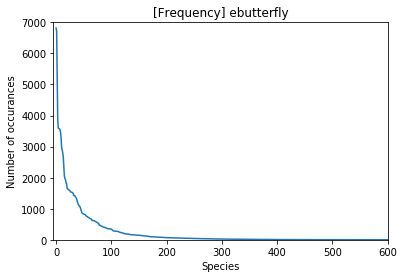

In [17]:
import matplotlib.pyplot as plt
import numpy as np

print(np.mean(species_freq), np.std(species_freq), np.max(species_freq))
x = np.arange(0, len(species_freq))
plt.plot(x, species_freq)
plt.ylim(0, 7000)
plt.xlim(-5, 601)
plt.xlabel("Species")
plt.ylabel("Number of occurances")
plt.title("[Frequency] ebutterfly")
plt.show()

106162.81492537314 2050091.0
106162.81492537314


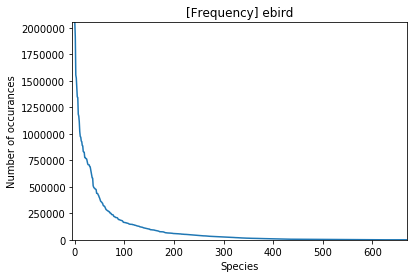

In [24]:
import matplotlib.pyplot as plt
import numpy as np

print(np.mean(ebird_freq), np.max(ebird_freq))
ebird_freq = np.sort(ebird_freq, axis=None)[::-1]
print(ebird_freq.mean())
x = np.arange(0, ebird_freq.shape[0])
plt.plot(x, ebird_freq)
plt.xlim(-5, 670)
plt.ylim(0, 2050091)
plt.xlabel("Species")
plt.ylabel("Number of occurances")
plt.title("[Frequency] ebird")
plt.show()

## Create final csv

In [ ]:
# columns: hotspot_name, lon, lat, number_of_observations, number_of_unique_checklists, number_of_unique_species, env variables
hotspot_ids = []
lats, lons = [], []
number_of_butterfly_obs = []
number_of_unique_checklists = []
number_of_different_species = []

bio_env_column_names = ['bio_1', 'bio_2', 'bio_3', 'bio_4', 'bio_5',
       'bio_6', 'bio_7', 'bio_8', 'bio_9', 'bio_10', 'bio_11', 'bio_12',
       'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18', 'bio_19']
ped_env_column_names = ['bdticm', 'bldfie', 'cecsol', 'clyppt', 'orcdrc', 'phihox', 'sltppt', 'sndppt']
location_info = ['county_code', 'state', 'state_code']

for group_name, group_data in tqdm(grouped_butterfly_data):
    hotspot_ids.append(group_name)
    lats.append(group_data['ebird_lat'].iloc[0])
    lons.append(group_data['ebird_lon'].iloc[0])
    number_of_butterfly_obs.append(len(group_data['occurrenceID']))
    number_of_unique_checklists.append(len(group_data['eventID'].unique()))
    number_of_different_species.append(len(group_data['species'].unique()))

final_data_frame = pd.DataFrame({'hotspot_id': hotspot_ids,
                                 'lat': lats,
                                 'lon': lons,
                                 'ebutterfly_occurances': number_of_butterfly_obs,
                                 'num_checklists': number_of_unique_checklists,
                                 'num_species': number_of_different_species})
    

indices = satbird_USA_summer[satbird_USA_summer['hotspot_id'].isin(final_data_frame['hotspot_id'])].index

bio_env_indices = [satbird_USA_summer.columns.get_loc(c) for c in bio_env_column_names]
ped_env_indices = [satbird_USA_summer.columns.get_loc(c) for c in ped_env_column_names]
location_info_indices = [satbird_USA_summer.columns.get_loc(c) for c in location_info]

final_data_frame[bio_env_column_names] = satbird_USA_summer.iloc[indices, bio_env_indices].values
final_data_frame[ped_env_column_names] = satbird_USA_summer.iloc[indices, ped_env_indices].values
final_data_frame[location_info] = satbird_USA_summer.iloc[indices, location_info_indices].values


print(final_data_frame)

final_data_frame.to_csv(os.path.join(root_dir, dataset_tag, 'butterfly_hotspots.csv') , index=False)

# 4. split data using DBSCAN (script: make_splits_by_distance.py)

In [ ]:
butterfly_data_with_split = pd.read_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_with_splits.csv"))

In [ ]:
butterfly_data_with_split

In [ ]:
grouped_butterfly_data = butterfly_data_with_split.groupby(['split'], as_index=False)

for group_name, group_data in tqdm(grouped_butterfly_data):
    print(group_name)
    print(group_data["ebutterfly_occurances"].max())
    group_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_" + str(group_name) + ".csv"))

# 5. Visualize map after splitting

In [ ]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))

import numpy as np
import pandas as pd
import json

import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

path = os.path.join(root_dir, dataset_tag, "butterfly_hotspots_with_splits.csv")

df = pd.read_csv(path)
df = df.drop_duplicates("hotspot_id")

geoDatav = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)   

ig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin(["02", "15"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
gdf[gdf["split"]=="train"].plot(ax=ax,marker='o', color='mediumslateblue', markersize=1, label = "train")
gdf[gdf["split"]=="val"].plot(ax=ax, marker='o', color='lightseagreen', markersize=1, label = "val")
gdf[gdf["split"]=="test"].plot(ax=ax, marker='o', color='lightsalmon', markersize=1, label = "test")

plt.legend(fontsize=16, markerscale=5,loc='lower right',  bbox_to_anchor=(0.92, 0.25))
plt.title("butterfly Hotspots")
plt.show()

Final files saved:
[('valid', 1002), ('test', 1005), ('train', 4677)]
- butterfly_hotspots.csv
- butterfly_hotspots_train.csv
- butterfly_hotspots_valid.csv
- butterfly_hotspots_test.csv
- species_list.csv
- targets/

#### Change the data splits to match ebird so we can co-train. This results in new splitting of [('valid', 1076), ('test', 958), ('train', 4650)] instead


In [ ]:
def resplit_ebutterfly_with_ebird(ebutterfly_df, ebird_df):
    out = ebutterfly_df.merge(ebird_df[['hotspot_id', 'split']], on='hotspot_id', how='right')
    ebutterfly_df = out[out['hotspot_id'].isin(ebutterfly_df['hotspot_id'])]
    print(ebutterfly_df['split'].value_counts())
    
    ebutterfly_df.to_csv(os.path.join(root_dir, dataset_tag, 'butterfly_hotspots_ebird_splits.csv') , index=False)

    grouped_butterfly_data = ebutterfly_df.groupby(['split'], as_index=False)

    for group_name, group_data in tqdm(grouped_butterfly_data):
        group_data.to_csv(os.path.join(root_dir, dataset_tag, "butterfly_hotspots_ebird_" + str(group_name) + ".csv"))
    
    
final_ebutterfly_df = pd.read_csv(os.path.join(root_dir, dataset_tag, 'butterfly_hotspots.csv'))
final_ebird_df = pd.read_csv(os.path.join(root_dir, dataset_tag, 'all_summer_hotspots_final.csv'))
resplit_ebutterfly_with_ebird(final_ebutterfly_df, final_ebird_df)